# Figure 2: within-subject encoding

In [2]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import pearsonr

from util import subject
from scipy.stats import zscore
from himalaya.scoring import correlation_score, correlation_score_split

from util import plot, stats
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

from matplotlib.colors import LinearSegmentedColormap, ListedColormap


# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [3]:
%cd ..

/scratch/gpfs/zzada/fconv


In [15]:
modelname = "joint_split"
# modelname = "joint_nosplit"
features = ["confounds", "stats", "acoustic", "articulatory", "LLM"]

modelname = "llm_split"
# # modelname = "llm_nosplit"
features = ["confounds", "LLM"]

# for variance partioning:
# modelname = "joint_split_nollm"
# features = ["confounds", "stats", "acoustic", "articulatory"]

suffix = ''
cache = 'default_task'
# cache = 'default_task_trial'

encmodel = f"encoding_{cache}{suffix}"

# # black story
# encmodel = "encoding_black"
# modelname = 'model-gpt2-2b_layer-24'
# features = ["stats", "acoustic", "articulatory", "LLM"]
# # modelname = 'contextual'
# # features = ["stats", "LLM"]

FG_MASK = get_brainmask()

cachedir = f'results/cache/figure2-{encmodel}/{modelname}/'
resultdir = f'figures/figure2/{encmodel}/{modelname}/'
!mkdir -p $resultdir
!mkdir -p $cachedir

modelname, encmodel, cache, cachedir

('llm_split',
 'encoding_default_task',
 'default_task',
 'results/cache/figure2-encoding_default_task/llm_split/')

In [5]:
catlas = Atlas.load("custom_glasser_group")
len(catlas)

22

# Load results

In [16]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

suffix = ''
suffix = '_exclusive'
# suffix = '_exclusive_mbc'

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")

    # respath.update(desc="bow")

    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        for key in [f"cv_scores_prod{suffix}", f"cv_scores_comp{suffix}"]:
            results[key].append(f[key][...])

100%|██████████| 58/58 [00:08<00:00,  7.05it/s]


In [ ]:
all_scores_prod = np.stack(results[f"cv_scores_prod{suffix}"])  # sub, run, feature, voxel
all_scores_comp = np.stack(results[f"cv_scores_comp{suffix}"])  # sub, run, feature, voxel
# all_scores_prod = np.stack(results[f"cv_scores_prod{suffix}"][1:])  # sub, run, feature, voxel
# all_scores_comp = np.stack(results[f"cv_scores_comp{suffix}"][1:])  # sub, run, feature, voxel
all_scores_prod.shape

(57, 5, 2, 81924)

In [21]:
avg_scores_prod = all_scores_prod.mean((0, 1))
avg_scores_comp = all_scores_comp.mean((0, 1))

llm_scores_prod = all_scores_prod[:, :, -1, :].mean(1)
llm_scores_comp = all_scores_comp[:, :, -1, :].mean(1)

avg_scores_prod.shape, llm_scores_prod.shape

((2, 81924), (57, 81924))

In [ ]:
# for black story where we don't have folds
if all_scores_prod.ndim < 4:
    print("black story exception")
    avg_scores_prod = all_scores_prod.mean(0)
    avg_scores_comp = all_scores_comp.mean(0)

    llm_scores_prod = all_scores_prod[:, -1, :]
    llm_scores_comp = all_scores_comp[:, -1, :]
avg_scores_prod.shape, llm_scores_prod.shape

# plot enc. performance per feature space

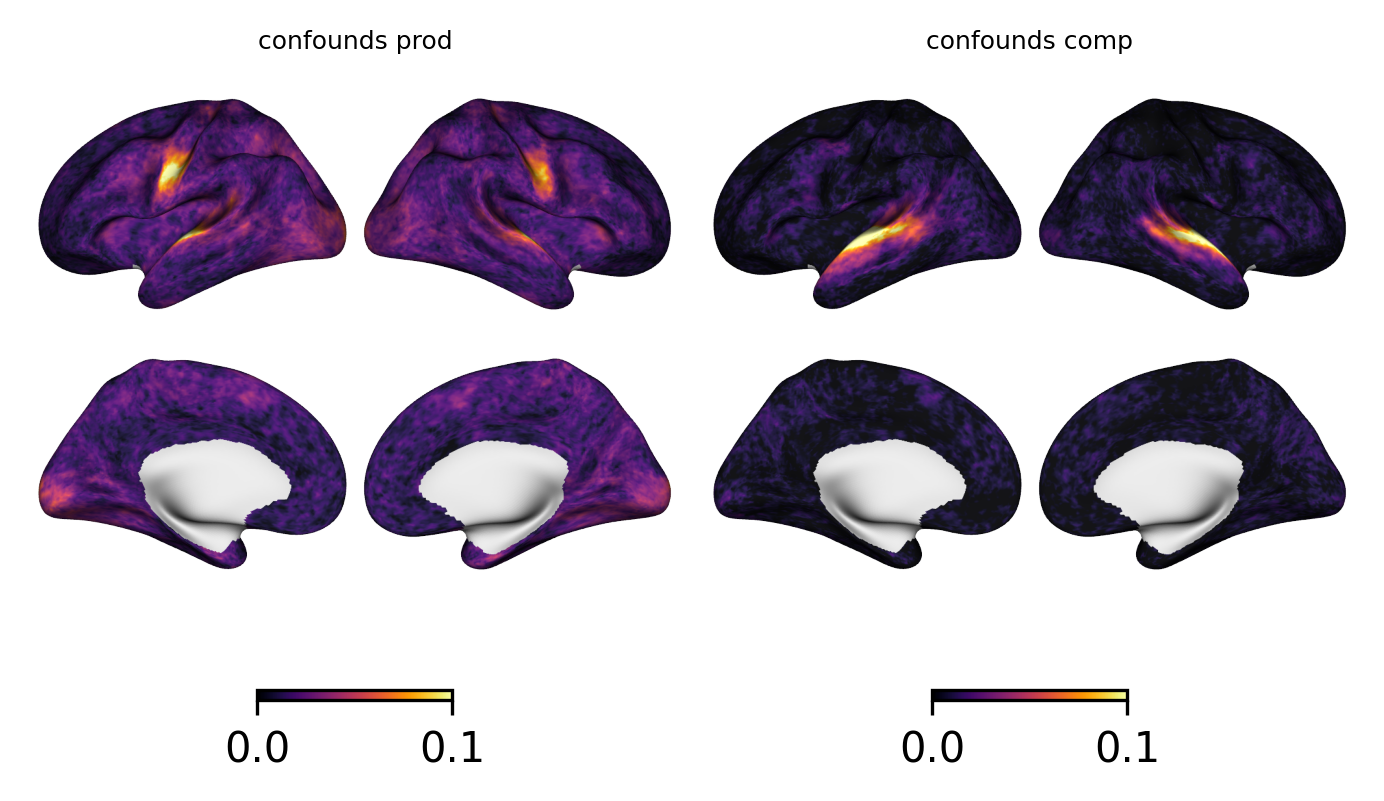

In [23]:
for i, feature in enumerate(features):
    fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
    plot.surface_plot(avg_scores_prod[i], vmin=0, vmax=0.1, cmap='inferno', fig=fig, ax=axes[0])
    plot.surface_plot(avg_scores_comp[i], vmin=0, vmax=0.1, cmap='inferno', fig=fig, ax=axes[1])
    axes[0].set_title(f"{feature} prod", fontsize=6)
    axes[1].set_title(f"{feature} comp", fontsize=6)
    fig.show()

In [8]:
joint_scores_prod = all_scores_prod[:, :, 2:].sum(2).mean(1)
joint_scores_comp = all_scores_comp[:, :, 2:].sum(2).mean(1)

prod_p_values = stats.ttest_1samp(joint_scores_prod, correlations=True)
comp_p_values = stats.ttest_1samp(joint_scores_comp, correlations=True)

joint_prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='bonf', alpha=0.001)
joint_comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='bonf', alpha=0.05)

print(joint_prod_sigmask.sum())
print(joint_comp_sigmask.sum())

16293
6200


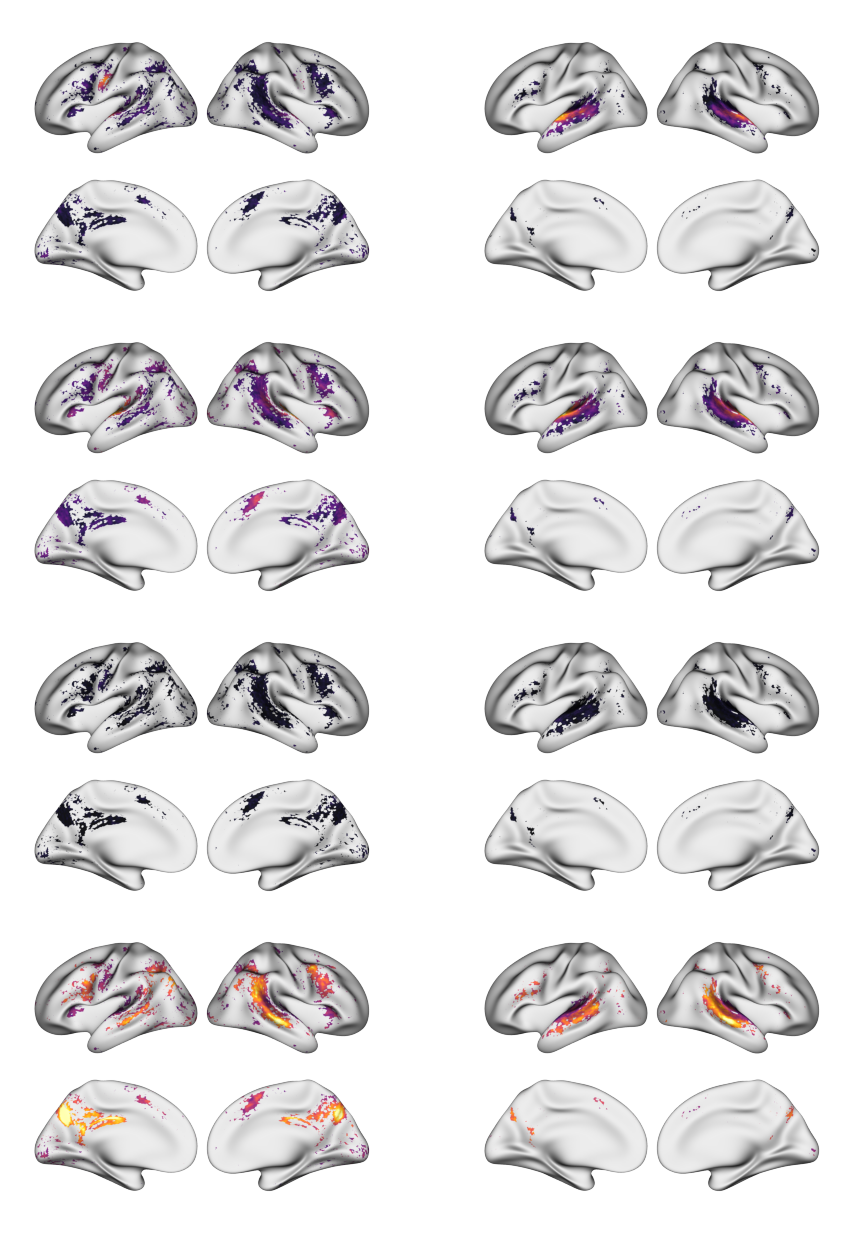

In [27]:
fig, axes = plt.subplots(4, 2, figsize=(3, 4), dpi=300, layout='constrained')
for i, feature in enumerate(features[1:], 0):
    plot.surface_plot(avg_scores_prod[i+1], vmin=0, vmax=0.1, cmap='inferno', cbar=False, threshold=~joint_prod_sigmask, fig=fig, ax=axes[i, 0])
    plot.surface_plot(avg_scores_comp[i+1], vmin=0, vmax=0.1, cmap='inferno', cbar=False, threshold=~joint_comp_sigmask, fig=fig, ax=axes[i, 1])
    # axes[0].set_title(f"{feature} prod", fontsize=6)
    # axes[1].set_title(f"{feature} comp", fontsize=6)
fig.show()

In [ ]:
# full encoding performance
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot(avg_scores_prod.sum(0), vmin=0, vmax=None, cmap='inferno', fig=fig, ax=axes[0])
plot.surface_plot(avg_scores_comp.sum(0), vmin=0, vmax=None, cmap='inferno', fig=fig, ax=axes[1])
fig.show()

# Statistical test

## one sample t-test

In [10]:
prod_p_values = stats.ttest_1samp(llm_scores_prod, correlations=True)
comp_p_values = stats.ttest_1samp(llm_scores_comp, correlations=True)

print((prod_p_values < .05).sum())
print((comp_p_values < .05).sum())

prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='fdr_by', alpha=0.001)
comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='fdr_by', alpha=0.01)

sigmask = prod_sigmask & comp_sigmask
common_sigmask = prod_sigmask | comp_sigmask

print(prod_sigmask.sum())
print(comp_sigmask.sum())
# print(sigmask.sum())

68970
58981
22481
14269


## black story

In [ ]:
prod_p_values = stats.ttest_1samp(llm_scores_prod, correlations=True, alternative='greater')
comp_p_values = stats.ttest_1samp(llm_scores_comp, correlations=True, alternative='greater')

print((prod_p_values < .05).sum())
print((comp_p_values < .05).sum())

prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='fdr_bh', alpha=0.05)
comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='fdr_bh', alpha=0.05)

sigmask = prod_sigmask & comp_sigmask
common_sigmask = prod_sigmask | comp_sigmask

print(prod_sigmask.sum())
print(comp_sigmask.sum())
# print(sigmask.sum())

## nonparametric bootstraping

In [ ]:
prod_bootstrap = stats.bootstrap_distribution(llm_scores_prod)
comp_bootstrap = stats.bootstrap_distribution(llm_scores_comp)
prod_bootstrap.shape 

In [ ]:
prod_p_values = stats.bootstrap_pvalues(avg_scores_prod[-1], prod_bootstrap)
comp_p_values = stats.bootstrap_pvalues(avg_scores_comp[-1], comp_bootstrap)
prod_p_values.shape

In [ ]:
# prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='fdr_by', alpha=0.005)
# comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='fdr_by', alpha=0.01)

# black
prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='fdr_bh', alpha=0.05)
comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='fdr_bh', alpha=0.05)

print(prod_sigmask.sum())
print(comp_sigmask.sum())

# mbc sig test

In [ ]:
llm_scores = (llm_scores_prod + llm_scores_comp) / 2
llm_scores.shape

In [ ]:
p_values = stats.ttest_1samp(llm_scores, correlations=True)
mbc_sigmask = stats.correct_multiple_tests(p_values, method='fdr_by', alpha=0.01)
prod_sigmask = mbc_sigmask
comp_sigmask = mbc_sigmask
print((p_values < .05).sum())
print(mbc_sigmask.sum())

17754
1619


In [69]:
mbc_bootstrap = stats.bootstrap_distribution(llm_scores)
mbc_p_values = stats.bootstrap_pvalues(llm_scores.mean(0), mbc_bootstrap)

In [70]:
mbc_sigmask = stats.correct_multiple_tests(mbc_p_values, method='fdr_bh', alpha=0.05)
prod_sigmask = mbc_sigmask
comp_sigmask = mbc_sigmask
mbc_sigmask.sum()

10143

In [73]:
values = llm_scores.mean(0)
vmin = values[mbc_sigmask].min()
print(values[mbc_sigmask].min())
print(values[mbc_sigmask].max())

0.005082595
0.06621212


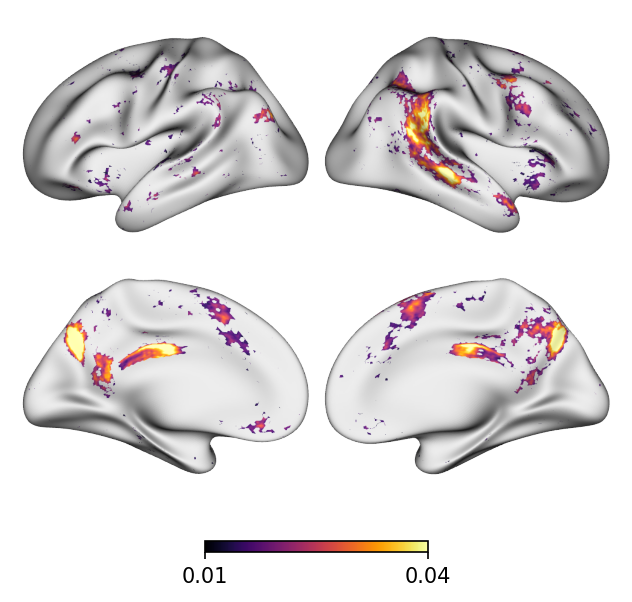

In [74]:
fig, ax = plt.subplots()
plot.surface_plot(values, cmap='inferno', vmin=vmin, threshold=~mbc_sigmask, fig=fig, ax=ax);
fig.savefig(f"{resultdir}/mbc.svg")
fig.show()

# Plot LLM encoding performance

PearsonRResult(statistic=0.7116802331713865, pvalue=0.0) 1.2206435232654656e-05


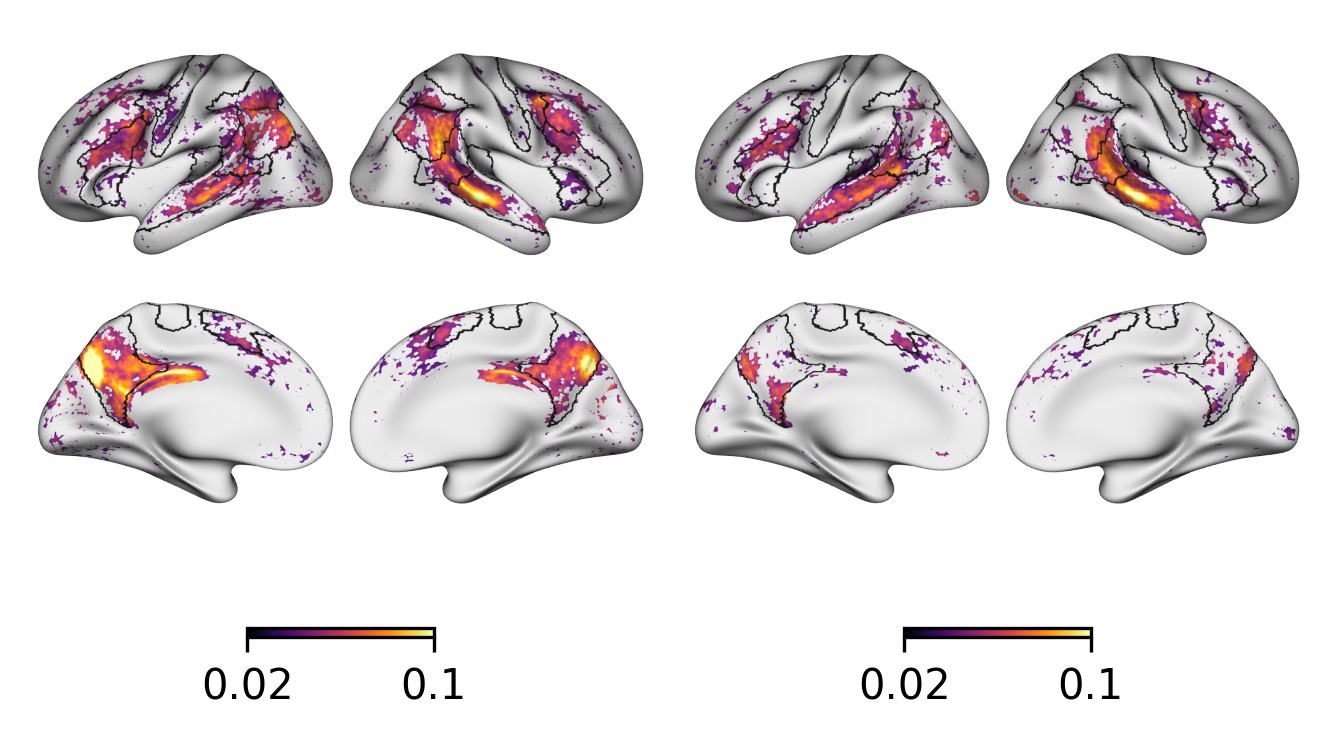

In [23]:
values1 = llm_scores_prod.mean(0)
values2 = llm_scores_comp.mean(0)

corr_out = pearsonr(values1[FG_MASK], values2[FG_MASK])
print(corr_out, 1/ len(values1))


fig, axes = plot.two_brain_fig(layout='tight', dpi=300)

# individual P/C sigmask
vmin = min(values1[prod_sigmask].min(), values2[comp_sigmask].min())
vmax = 0.1

# vmax = 0.05

plot.surface_plot(values1, threshold=~prod_sigmask, fig=fig, ax=axes[0], cmap='inferno', vmin=vmin, vmax=vmax, atlas=catlas, atlas_cmap="gray")
plot.surface_plot(values2, threshold=~comp_sigmask, fig=fig, ax=axes[1], cmap='inferno', vmin=vmin, vmax=vmax, atlas=catlas)

# common sigmask
# vmin = values1[sigmask].min()
# plot.surface_plot(values1, threshold=~sigmask, fig=fig, ax=axes[0], cmap='inferno', vmin=vmin, vmax=vmax)
# vmin = values2[sigmask].min()
# plot.surface_plot(values2, threshold=~sigmask, fig=fig, ax=axes[1], cmap='inferno', vmin=vmin, vmax=vmax)

# axes[0].set_title("production")
# axes[1].set_title("comprehension")
# fig.suptitle(modelname[6:] + f" ({len(features)} spaces) ({cache})")

fig.savefig(f"{resultdir}/brainmap-prod-comp-llm-performance_outline.svg")
fig.show()

In [ ]:
values = (prod_sigmask & comp_sigmask).astype(int)  # overlap
# values = (prod_sigmask & np.logical_not(comp_sigmask)).astype(int)  # prod only
# values = (comp_sigmask & np.logical_not(prod_sigmask)).astype(int)  # comp only
plot.surface_plot(values, cmap='Grays', vmin=0, vmax=1, cbar=False);

## difference

In [ ]:
colors = [BLU, '#ffffff', ORG]
colors = [BLU, '#000000', ORG]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
cmap

In [ ]:
llm_scores_prod = all_scores_prod[:, :, -1, :].mean(1)
llm_scores_comp = all_scores_comp[:, :, -1, :].mean(1)

difference = llm_scores_comp.mean(0) - llm_scores_prod.mean(0)

In [ ]:
# all_difference = llm_scores_comp - llm_scores_prod
# diff_sigmask = ttest_1samp(all_difference, method='fdr_bh', alpha=0.15)
# diff_sigmask.sum()

In [ ]:
plot.surface_plot(difference, cmap=cmap, threshold=~common_sigmask);

# scatter prod and comp

In [ ]:
values1 = avg_scores_prod[-1][FG_MASK]
values2 = avg_scores_comp[-1][FG_MASK]
corr_out = pearsonr(values1, values2)
corr_out, 1/ len(values1)

In [ ]:
# no colors
fig, ax = plt.subplots(figsize=(2.75, 3.75), dpi=300)

ax.scatter(values1, values2, s=10, c='k', alpha=.5, edgecolors=None, linewidths=0, marker='.')
# im = ax.hexbin(values1, values2, gridsize=50, bins='log', cmap='viridis')
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dotted')

ax.set_aspect("equal", "box")
lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)
# ax.set_xticks(np.arange(0, .16, .05))
# ax.set_yticks(np.arange(0, .16, .05))

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

ax.text(x=0.02, y=1, s=f"r={corr_out.statistic:0.3f}", transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left', fontsize=8)

# cb = fig.colorbar(im, ax=ax, shrink=0.5)

fig.show()

In [ ]:
vmax = max(values1.max(), values2.max())
print(vmax)
vmax = 0.1
vox_colors = plot.Colormap2D(vmin=0, vmin2=0, vmax=vmax, vmax2=vmax)(
    np.vstack((values1, values2)).T
)
vox_colors = np.stack((vox_colors)).T / 255

In [ ]:
fig, ax = plt.subplots(figsize=(2.75, 2.75), dpi=300)

# ax.scatter(values1, values2, c=vox_colors, s=20, edgecolors='black', linewidths=0.25, marker='o')
ax.scatter(values1, values2, c=vox_colors, s=10, edgecolors='black', linewidths=0.25, marker='.')
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dashed')

ax.set_aspect("equal", "box")
lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)
ax.set_xticks(np.arange(0, .16, .05))
ax.set_yticks(np.arange(0, .16, .05))

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

ax.text(x=0.02, y=1, s=f"r={corr_out.statistic:0.3f}", transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left', fontsize=8)

fig.show()

# Joint ROI-level

In [ ]:
# df_count = pd.DataFrame(index=catlas.labels)
# df_count['prod'] = catlas.vox_to_parc(prod_sigmask.astype(int), agg_func=np.sum)
# df_count['comp'] = catlas.vox_to_parc(comp_sigmask.astype(int), agg_func=np.sum)
# df_count['total'] = [catlas.parcel_vcount[i] for i in range(1, len(catlas)+1)]
# df_count

In [ ]:
scoresP = catlas.vox_to_parc(avg_scores_prod)
errorsP = catlas.vox_to_parc(all_scores_prod[:, :, -1].mean(1)).std(0) / np.sqrt(len(all_scores_prod))
errorsPfull = catlas.vox_to_parc(all_scores_prod.sum(2).mean(1).std(0) / np.sqrt(len(all_scores_prod)))
# errorsP = catlas.vox_to_parc(avg_scores_prod, agg_func=np.std) / np.sqrt(df_count['total']).to_numpy()

# # for sig
# scoresP = avg_scores_prod.copy()
# scoresP[:, ~prod_sigmask] = np.nan
# errorsP = catlas.vox_to_parc(scoresP, agg_func=np.nanstd) / np.sqrt(df_count['prod']).to_numpy()
# scoresP = catlas.vox_to_parc(scoresP, agg_func=np.nanmean)

df_prod = pd.DataFrame(index=catlas.labels)
df_prod_err = pd.DataFrame(index=catlas.labels)
for i, feature in enumerate(features):
    df_prod[feature] = scoresP[i]
    df_prod_err[feature] = errorsP[i]
df_prod.head()

confounds     stats  acoustic  articulatory       LLM
LH_EAC    0.003753  0.019962  0.047565      0.001549  0.024946
LH_pSTG   0.002831  0.014127  0.023302      0.003642  0.042048
LH_aSTG   0.001384  0.016442  0.020298      0.003084  0.042058
LH_IFG    0.002000  0.009417  0.014491      0.003484  0.042074
LH_FOP    0.001627  0.010256  0.021533      0.003079  0.026395

In [ ]:
scoresC = catlas.vox_to_parc(avg_scores_comp)
errorsC = catlas.vox_to_parc(all_scores_comp[:, :, -1].mean(1)).std(0) / np.sqrt(len(all_scores_comp))
errorsCfull = catlas.vox_to_parc(all_scores_comp.sum(2).mean(1).std(0) / np.sqrt(len(all_scores_comp)))
# errorsC = catlas.vox_to_parc(avg_scores_comp, agg_func=np.std) / np.sqrt(df_count['total']).to_numpy()

# # for sig
# scoresC = avg_scores_comp.copy()
# scoresC[:, ~comp_sigmask] = np.nan
# errorsC = catlas.vox_to_parc(scoresC, agg_func=np.nanstd) / np.sqrt(df_count['comp']).to_numpy()
# scoresC = catlas.vox_to_parc(scoresC, agg_func=np.nanmean)

df_comp = pd.DataFrame(index=catlas.labels)
df_comp_err = pd.DataFrame(index=catlas.labels)
for i, feature in enumerate(features):
    df_comp[feature] = scoresC[i]
    df_comp_err[feature] = errorsC[i]
df_comp.head()

confounds     stats  acoustic  articulatory       LLM
LH_EAC    0.024379  0.017876  0.042594      0.001329  0.028447
LH_pSTG   0.006399  0.015812  0.019823      0.002883  0.046100
LH_aSTG   0.004094  0.032184  0.026180      0.004156  0.047681
LH_IFG    0.001465  0.005974  0.007930      0.002436  0.038535
LH_FOP    0.000981  0.004629  0.008285      0.000770  0.021502

## just LLM

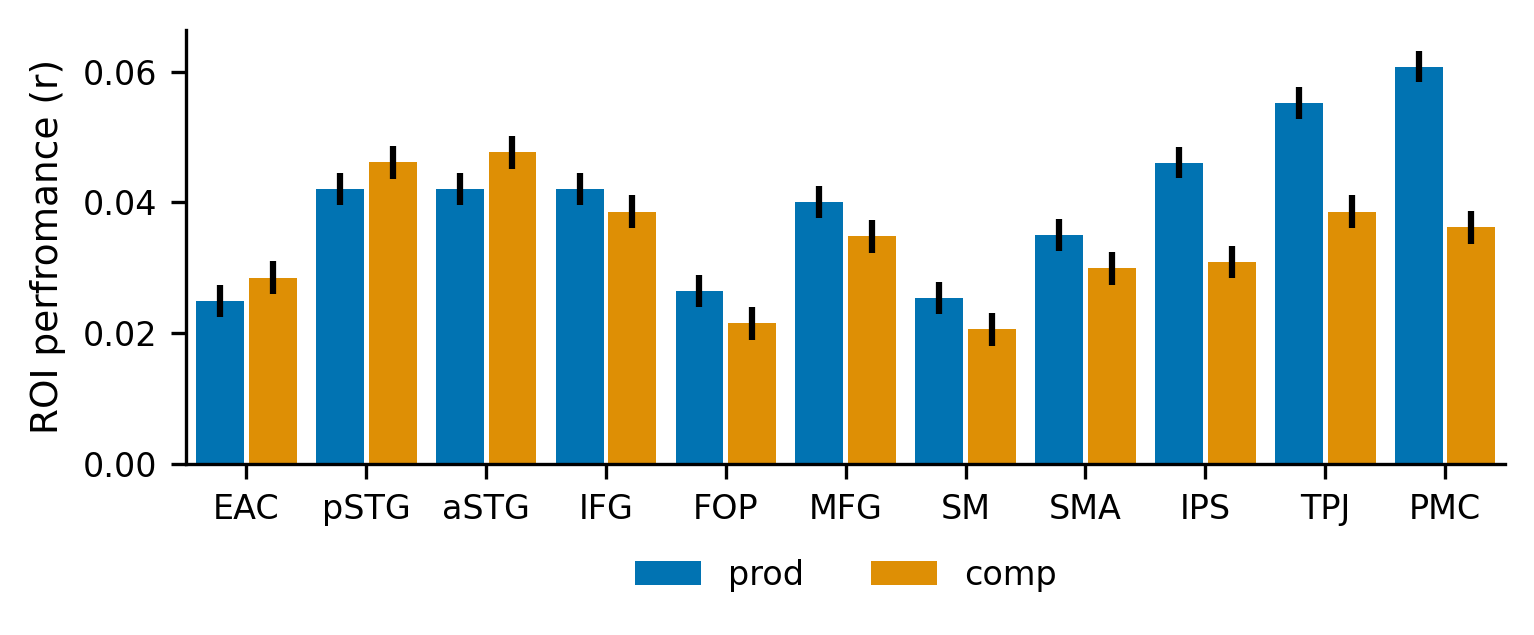

In [46]:
fig, ax = plt.subplots(figsize=(5, 2), layout='constrained', dpi=300)

half = len(catlas) // 2
hemi_slice = slice(None, half)  # LH
# hemi_slice = slice(half, None)  # RH

xlabels = catlas.labels[hemi_slice]
xaxis = np.arange(len(xlabels))
width = 0.4

values = df_prod.iloc[hemi_slice, -1]
errors = df_prod_err.iloc[hemi_slice, -1]
p = ax.bar(xaxis - .02, values, -width, yerr=errors, label='prod', color=BLU, align='edge', alpha=1.0)

values = df_comp.iloc[hemi_slice, -1]
errors = df_comp_err.iloc[hemi_slice, -1]
p = ax.bar(xaxis + .02, values, width, yerr=errors, label='comp', color=ORG, align='edge', alpha=1.0)

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels])

gap = .1
ax.set_xlim(-width-gap, 10+width+gap)
# ax.set_ylim(0, 0.06)

ax.set_ylabel('ROI perfromance (r)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

# fig.savefig(f"{resultdir}/barplot-joint.svg")
fig.show()

## all bands

In [33]:
df_prod['confounds'] = df_prod['confounds'] + df_prod['stats']
df_prod.drop('stats', axis=1, inplace=True)

In [34]:
df_comp['confounds'] = df_comp['confounds'] + df_comp['stats']
df_comp.drop('stats', axis=1, inplace=True)

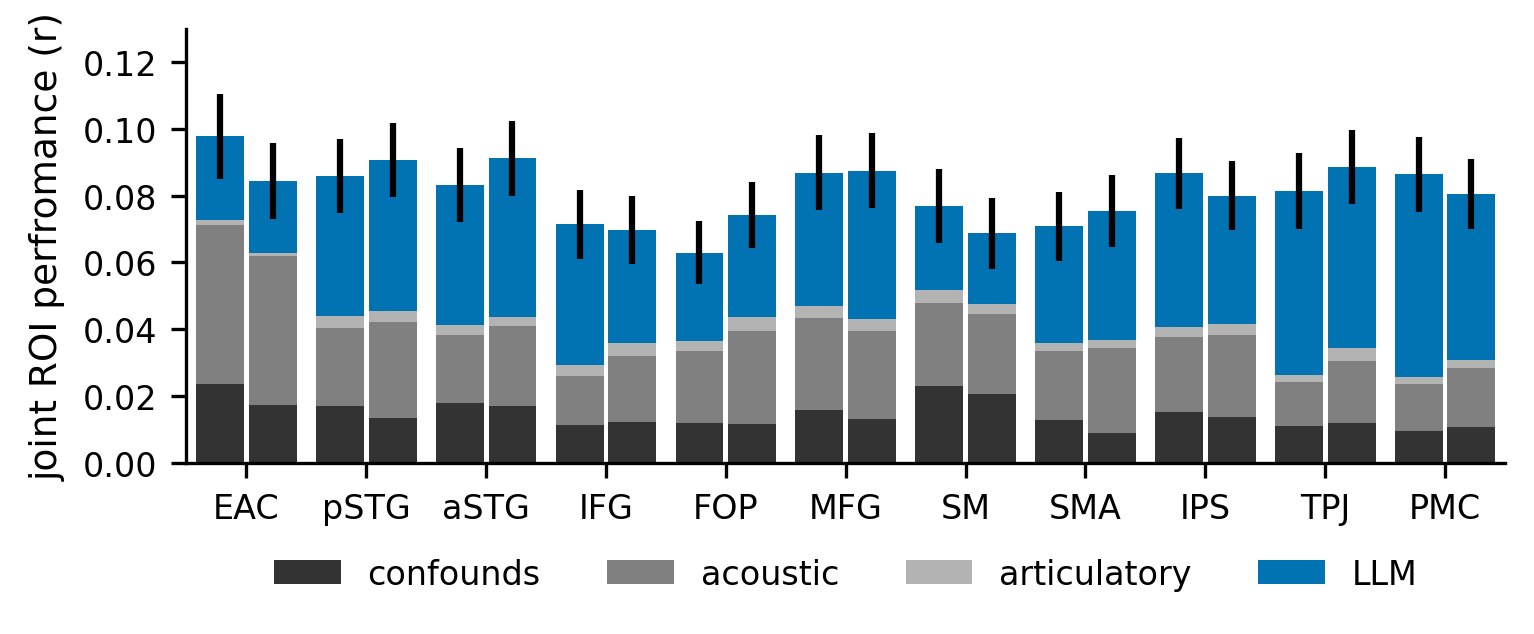

In [45]:
width = 0.4

fig, ax = plt.subplots(figsize=(5, 2), layout='constrained', dpi=300)

half = len(catlas) // 2
lh_slice = slice(None, half)  # LH
rh_slice = slice(half, None)  # RH

subdf1 = df_prod.iloc[lh_slice]
subdf = df_prod.iloc[rh_slice]
xlabels = subdf.index
bottom = np.zeros(len(xlabels))
colors = ["#333333", "#808080", "#b3b3b3", BLU]  # 80% gray, .., 30% gray
plot_features = df_prod.columns

xaxis = np.arange(len(xlabels))

for feature, color in zip(plot_features, colors):
    values = subdf1[feature]
    yerr = None
    if feature == 'LLM': yerr = errorsPfull[lh_slice]
    p = ax.bar(xaxis - .02, values, -width, yerr=yerr, bottom=bottom, color=color, align='edge')
    bottom += values

bottom = np.zeros(len(xlabels))
for feature, color in zip(plot_features, colors):
    values = subdf[feature]
    yerr = None
    if feature == 'LLM': yerr = errorsPfull[rh_slice]
    p = ax.bar(xaxis + .02, values, width, yerr=yerr, label=feature, bottom=bottom, color=color, align='edge')
    bottom += values

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels])

gap = .1
ax.set_xlim(-width-gap, 10+width+gap)
ax.set_ylim(0, .13)
ax.set_yticks(np.arange(0, 0.131, .02))

ax.set_ylabel('joint ROI perfromance (r)')
# ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.98, 1))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

fig.savefig(f"{resultdir}/barplot-prod-joint.svg")
fig.show()

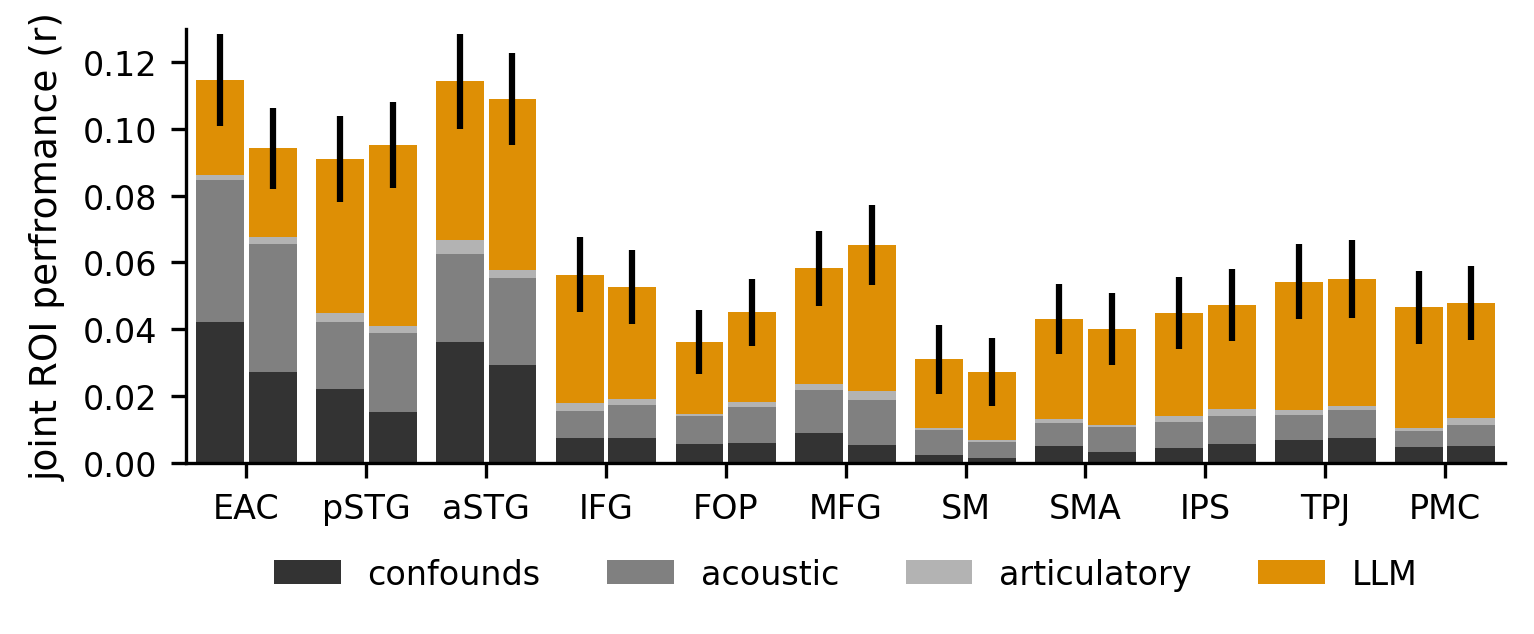

In [44]:
width = 0.4

fig, ax = plt.subplots(figsize=(5, 2), layout='constrained', dpi=300)

subdf1 = df_comp.iloc[lh_slice]
subdf = df_comp.iloc[rh_slice]
xlabels = subdf.index
bottom = np.zeros(len(xlabels))
colors = ["#333333", "#808080", "#b3b3b3", ORG]  # 80% gray, .., 30% gray
plot_features = df_comp.columns

xaxis = np.arange(len(xlabels))

for feature, color in zip(plot_features, colors):
    values = subdf1[feature]
    yerr = None
    if feature == 'LLM': yerr = errorsCfull[lh_slice]
    p = ax.bar(xaxis - .02, values, -width, yerr=yerr, bottom=bottom, color=color, align='edge')
    bottom += values

bottom = np.zeros(len(xlabels))

for feature, color in zip(plot_features, colors):
    values = subdf[feature]
    yerr = None
    if feature == 'LLM': yerr = errorsCfull[rh_slice]
    p = ax.bar(xaxis + .02, values, width, yerr=yerr, label=feature, bottom=bottom, color=color, align='edge')
    bottom += values

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels])

gap = .1
ax.set_xlim(-width-gap, 10+width+gap)
ax.set_ylim(0, .13)
ax.set_yticks(np.arange(0, 0.131, .02))

ax.set_ylabel('joint ROI perfromance (r)')
# ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.98, 1))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

fig.savefig(f"{resultdir}/barplot-comp-joint.svg")
fig.show()

In [ ]:
pc_diff = (df_prod.LLM - df_comp.LLM) / (df_prod.LLM + df_comp.LLM)
diff_df = pc_diff.to_frame()

In [ ]:
width = 0.4

fig, ax = plt.subplots(figsize=(5, 2), layout='constrained', dpi=300)

subdf1 = diff_df.iloc[:len(diff_df)//2]
subdf = diff_df.iloc[len(diff_df)//2:]
xlabels = subdf.index
bottom = np.zeros(len(xlabels))
colors = ["#333333", "#7f7f7f", "#CCCCCC", ORG]
plot_features = diff_df.columns

xaxis = np.arange(len(xlabels))

for feature, color in zip(plot_features, colors):
    values = subdf1[feature]
    p = ax.bar(xaxis - .02, values, -width, bottom=bottom, color=color, align='edge')
    bottom += values

bottom = np.zeros(len(xlabels))

for feature, color in zip(plot_features, colors):
    values = subdf[feature]
    p = ax.bar(xaxis + .02, values, width, label=feature, bottom=bottom, color=color, align='edge')
    bottom += values

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels])

gap = .1
ax.set_xlim(-width-gap, 10+width+gap)
# ax.set_ylim(0, .12)

ax.set_ylabel('joint ROI perfromance (r)')
# ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.98, 1))
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

fig.show()

## plot brains

In [ ]:
from surfplot import Plot

In [ ]:
for i, label in enumerate(catlas.labels[:len(catlas)//2], 1):
    roimask = catlas.roimask([i]).astype(int)

    view = 'lateral'
    if 'SMA' in label or 'PMC' in label:
        view = 'medial'

    p = Plot("mats/suma-fsaverage6/lh.inf_120.gii", views=view, brightness=0.7, size=(200, 200), zoom=1.2)
    p.add_layer(roimask[:roimask.size//2], cmap='Grays', color_range=(0, 1), cbar=False)
    fig = p.build()
    fig.savefig(f"{resultdir}/roi-{label}_map.svg")
    fig.show()

# check alphas

In [ ]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

alphas = []
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        alphas.append(f['cv_alphas'][...])

In [ ]:
alphas = np.stack(alphas)
alphas = alphas[..., FG_MASK]
# best_alphas = alphas.mean((0,1))
best_alphas = alphas.mean((0,1))
alphas.shape

In [ ]:
np.log10(alphas.max())

In [ ]:
values = np.zeros(81924)
values[FG_MASK] = (np.log10(alphas) > 10).any((0,1))
plot.surface_plot(values, cmap='viridis', vmin=0);

In [ ]:
plt.hist(np.log10(alphas.ravel()), bins=13);

In [ ]:
plot.surface_plot(np.log10(best_alphas), cmap='viridis', vmin=0, vmax=15);

# model comparisons

In [5]:
models = ['joint_split', 'joint_nosplit']
features = ["confounds", "stats", "acoustic", "articulatory", "LLM"]

# models = ['llm_split', 'llm_nosplit']
# features = ["confounds", "LLM"]

suffix = ''
cache = 'default_task'

encmodel = f"encoding_{cache}{suffix}"

FG_MASK = get_brainmask()

modelname = '-'.join(models)
cachedir = f'results/cache/figure2-{encmodel}/{modelname}/'
resultdir = f'figures/figure2/{encmodel}/{modelname}/'
!mkdir -p $resultdir
!mkdir -p $cachedir

modelname, encmodel, cache, cachedir

('joint_split-joint_nosplit',
 'encoding_default_task',
 'default_task',
 'results/cache/figure2-encoding_default_task/joint_split-joint_nosplit/')

In [6]:
model_results = {}
for modelname in models:
    respath = Path(
        root='results/' + encmodel,
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    suffix = ''
    suffix = '_exclusive'

    results = defaultdict(list)
    for sub in tqdm(SUBS_STRANGERS):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print("skip", respath.fpath)
            continue
        with h5py.File(respath, "r") as f:
            for key in [f"cv_scores_prod{suffix}", f"cv_scores_comp{suffix}"]:
                results[key].append(f[key][...])
    model_results[modelname] = results

100%|██████████| 58/58 [00:01<00:00, 29.06it/s]


In [7]:
# prefix = 'llm'
prefix = 'joint'
model1_prod_scores = np.stack(model_results[f'{prefix}_split']['cv_scores_prod_exclusive'])
model1_comp_scores = np.stack(model_results[f'{prefix}_split']['cv_scores_comp_exclusive'])
model2_prod_scores = np.stack(model_results[f'{prefix}_nosplit']['cv_scores_prod_exclusive'])
model2_comp_scores = np.stack(model_results[f'{prefix}_nosplit']['cv_scores_comp_exclusive'])
model1_prod_scores.shape, model2_prod_scores.shape

((58, 5, 5, 81924), (58, 5, 5, 81924))

In [8]:
model1_llm_prod_scores = model1_prod_scores.mean(1)[:, -1]
model1_llm_comp_scores = model1_comp_scores.mean(1)[:, -1]
model2_llm_prod_scores = model2_prod_scores.mean(1)[:, -1]
model2_llm_comp_scores = model2_comp_scores.mean(1)[:, -1]
model2_llm_comp_scores.shape 

(58, 81924)

## roi bar plot

In [9]:
records = {}
records_err = {}
for modelname in models:
    model_result = model_results[modelname]
    for mode in ('prod', 'comp'):
        key = f'cv_scores_{mode}_exclusive'
        temp_result = np.stack(model_result[key])  # (58, 5, 5, n_vox)
        temp_result = catlas.vox_to_parc(temp_result)
        temp_result = temp_result[:, :, -1]  # only llm performance
        temp_result = temp_result.mean(1)  # avg over runs
        temp_result_err = temp_result.std(0) / np.sqrt(temp_result.shape[0])
        temp_result = temp_result.mean(0)  # avg over subjects
        records[f'{modelname}_{mode}'] = temp_result
        records_err[f'{modelname}_{mode}'] = temp_result_err
        print(modelname, temp_result.shape)

df = pd.DataFrame(records, index=catlas.labels)
df_err = pd.DataFrame(records_err, index=catlas.labels)
df

joint_split (22,)
joint_split (22,)
joint_nosplit (22,)
joint_nosplit (22,)


joint_split_prod  joint_split_comp  joint_nosplit_prod  \
LH_EAC           0.024946          0.028447            0.018467   
LH_pSTG          0.042048          0.046100            0.035456   
LH_aSTG          0.042058          0.047681            0.036857   
LH_IFG           0.042074          0.038535            0.031854   
LH_FOP           0.026395          0.021502            0.021440   
LH_MFG           0.040085          0.034785            0.028581   
LH_SM            0.025359          0.020539            0.017058   
LH_SMA           0.034967          0.029937            0.025384   
LH_IPS           0.046085          0.030867            0.034112   
LH_TPJ           0.055225          0.038529            0.046332   
LH_PMC           0.060794          0.036158            0.051246   
RH_EAC           0.021552          0.026683            0.015346   
RH_pSTG          0.045242          0.054175            0.044784   
RH_aSTG          0.047480          0.051076            0.043959   
RH_IFG           0.033838          0.033799            0.028013   
RH_FOP           0.030570          0.026863            0.026851   
RH_MFG           0.044350          0.043664            0.036542   
RH_SM            0.021101          0.020540            0.012105   
RH_SMA           0.038721          0.028956            0.033715   
RH_IPS           0.038440          0.031088            0.031019   
RH_TPJ           0.054263          0.038158            0.050300   
RH_PMC           0.049714          0.034520            0.044838   

         joint_nosplit_comp  
LH_EAC             0.017813  
LH_pSTG            0.037857  
LH_aSTG            0.039939  
LH_IFG             0.029988  
LH_FOP             0.016204  
LH_MFG             0.024611  
LH_SM              0.012348  
LH_SMA             0.021813  
LH_IPS             0.022098  
LH_TPJ             0.032076  
LH_PMC             0.030399  
RH_EAC             0.015783  
RH_pSTG            0.050544  
RH_aSTG            0.045105  
RH_IFG             0.027965  
RH_FOP             0.023500  
RH_MFG             0.037089  
RH_SM              0.010292  
RH_SMA             0.025565  
RH_IPS             0.025754  
RH_TPJ             0.037613  
RH_PMC             0.030403

In [23]:
df['joint_nosplit_prod'][lh_slice].values + df['joint_nosplit_prod'][rh_slice].values

array([0.03381312, 0.08023979, 0.08081549, 0.05986708, 0.04829068,
       0.06512289, 0.02916335, 0.05909856, 0.0651308 , 0.09663253,
       0.09608433], dtype=float32)

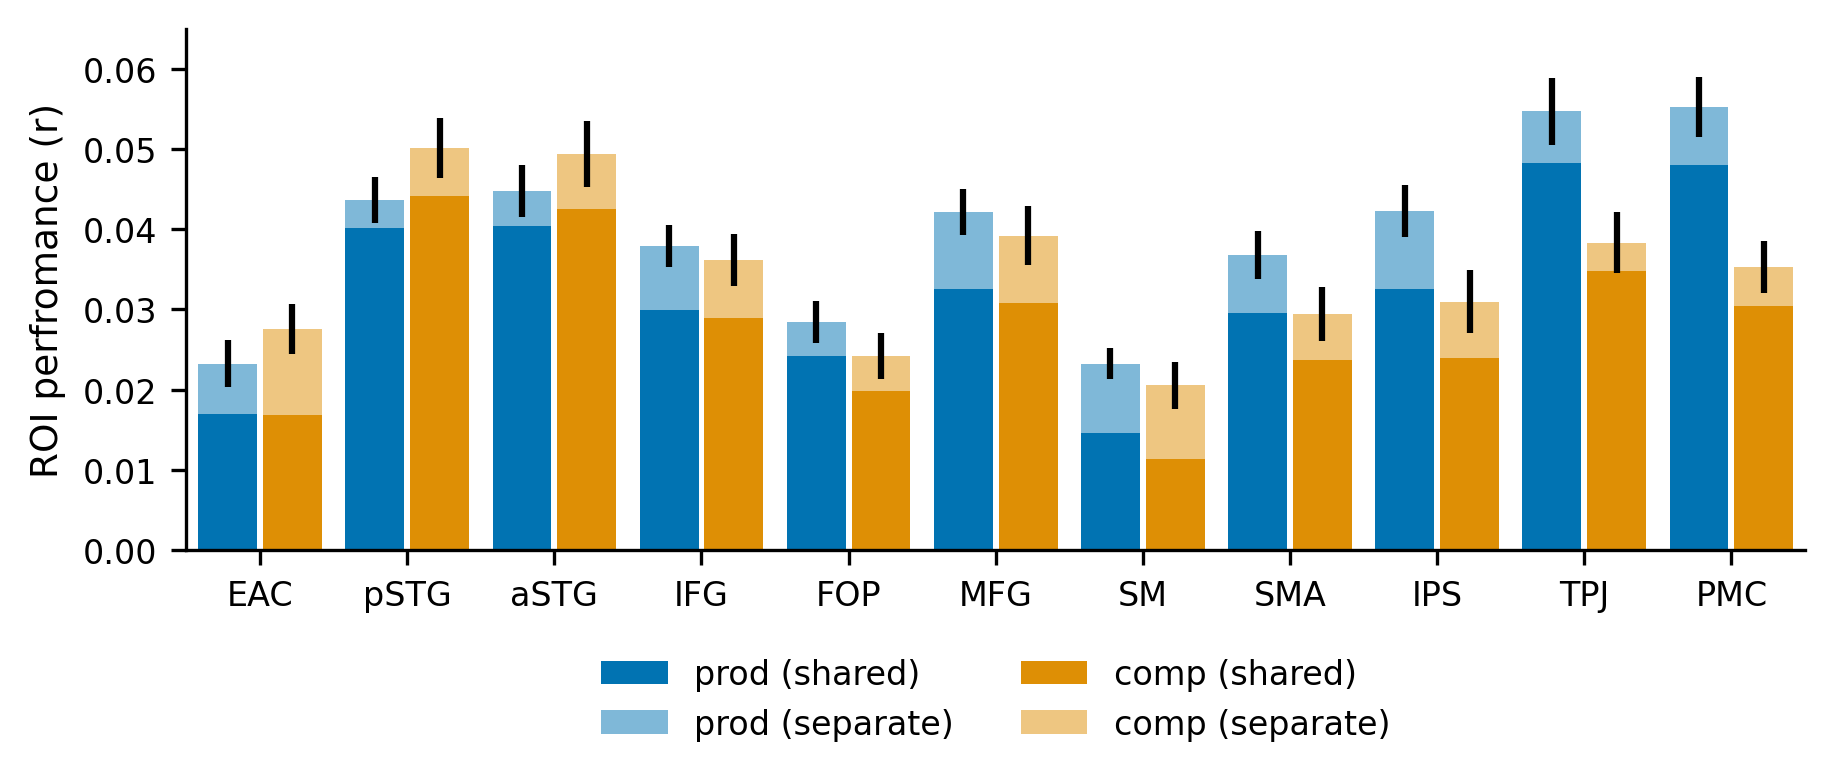

In [28]:
fig, ax = plt.subplots(figsize=(6, 2.5), layout='constrained', dpi=300)

half = len(catlas) // 2
lh_slice = slice(None, half)  # LH
rh_slice = slice(half, None)  # RH

xlabels = catlas.labels[lh_slice]
xaxis = np.arange(len(xlabels))
width = 0.4

values = (df['joint_nosplit_prod'][lh_slice].values + df['joint_nosplit_prod'][rh_slice].values) / 2
errors = None
p = ax.bar(xaxis - .02, values, -width, yerr=errors, label='prod (shared)', color=BLU, align='edge', alpha=1.0)

values = (df['joint_split_prod'][lh_slice].values + df['joint_split_prod'][rh_slice].values) / 2
errors = (df_err['joint_split_prod'][lh_slice].values + df_err['joint_split_prod'][rh_slice].values) / 2
p = ax.bar(xaxis - .02, values, -width, yerr=errors, label='prod (separate)', color=BLU, align='edge', alpha=0.5)

values = (df['joint_nosplit_comp'][lh_slice].values + df['joint_nosplit_comp'][rh_slice].values) / 2
errors = None
p = ax.bar(xaxis + .02, values, width, yerr=errors, label='comp (shared)', color=ORG, align='edge', alpha=1.0)

values = (df['joint_split_comp'][lh_slice].values + df['joint_split_comp'][rh_slice].values) / 2
errors = (df_err['joint_split_comp'][lh_slice].values + df_err['joint_split_comp'][rh_slice].values) / 2
p = ax.bar(xaxis + .02, values, width, yerr=errors, label='comp (separate)', color=ORG, align='edge', alpha=0.5)

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels])

gap = .1
ax.set_xlim(-width-gap, 10+width+gap)
ax.set_ylim(0, 0.065)

ax.set_ylabel('ROI perfromance (r)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

fig.savefig(f"{resultdir}/barplot-joint-shared_separate.svg")
fig.show()

## difference

In [ ]:
diff_prod_scores = model1_llm_prod_scores - model2_llm_prod_scores
diff_comp_scores = model1_llm_comp_scores - model2_llm_comp_scores
avg_diff_prod = diff_prod_scores.mean(0)
avg_diff_comp = diff_comp_scores.mean(0)
diff_prod_scores.shape, avg_diff_prod.shape

In [ ]:
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot(avg_diff_prod, vmin=None, vmax=None, cmap='seismic', fig=fig, ax=axes[0])
plot.surface_plot(avg_diff_comp, vmin=None, vmax=None, cmap='seismic', fig=fig, ax=axes[1])
fig.show()

In [ ]:
from statsmodels.stats.multitest import multipletests

In [ ]:
prod_p_values = stats.ttest_1samp(diff_prod_scores, correlations=True)
comp_p_values = stats.ttest_1samp(diff_comp_scores, correlations=True)

diff_prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='fdr_bh', alpha=0.05)
diff_comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='fdr_bh', alpha=0.05)

# outputs = multipletests(prod_p_values[prod_sigmask], alpha=0.05, method='fdr_bh')
# diff_prod_sigmask = np.zeros_like(prod_p_values, dtype=bool)
# diff_prod_sigmask[*prod_sigmask.nonzero()] = outputs[0]
# outputs = multipletests(comp_p_values[comp_sigmask], alpha=0.05, method='fdr_bh')
# diff_comp_sigmask = np.zeros_like(comp_p_values, dtype=bool)
# diff_comp_sigmask[*comp_sigmask.nonzero()] = outputs[0]

print(diff_prod_sigmask.sum())
print(diff_comp_sigmask.sum())

In [ ]:
diff_prod_sigmask &= prod_sigmask
diff_comp_sigmask &= comp_sigmask

print(diff_prod_sigmask.sum())
print(diff_comp_sigmask.sum())

In [ ]:
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot(avg_diff_prod, vmin=None, vmax=None, cmap='seismic', fig=fig, ax=axes[0], threshold=~diff_prod_sigmask)
plot.surface_plot(avg_diff_comp, vmin=None, vmax=None, cmap='seismic', fig=fig, ax=axes[1], threshold=~diff_comp_sigmask)
fig.show()

## difference per feature space

In [ ]:
for i, feature in enumerate(features):
    fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
    plot.surface_plot(diff_avg_prod_scores[i], vmin=0, vmax=None, cmap='inferno', fig=fig, ax=axes[0])
    plot.surface_plot(diff_avg_comp_scores[i], vmin=0, vmax=None, cmap='inferno', fig=fig, ax=axes[1])
    axes[0].set_title(f"{feature} prod", fontsize=6)
    axes[1].set_title(f"{feature} comp", fontsize=6)
    fig.show()

In [ ]:
# no colors
fig, axes = plt.subplots(1, 2, figsize=(2.75, 3.75), dpi=300, sharex=True, sharey=True)

ax = axes[0]
ax.scatter(model1_avg_prod_scores[-1][prod_sigmask],
           model2_avg_prod_scores[-1][prod_sigmask],
           s=10, c='k', alpha=.5, edgecolors=None, linewidths=0, marker='.')
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dotted')
ax.set_aspect("equal", "box")
ax.set_title('production')

ax = axes[1]
ax.scatter(model1_avg_comp_scores[-1][comp_sigmask],
           model2_avg_comp_scores[-1][comp_sigmask],
           s=10, c='k', alpha=.5, edgecolors=None, linewidths=0, marker='.')
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dotted')
ax.set_aspect("equal", "box")
ax.set_title('comprehension')

lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)
ax.set_xticks(np.arange(0, .16, .05))
ax.set_yticks(np.arange(0, .16, .05))

axes[0].set_ylabel("nosplit model")
axes[0].set_xlabel("split encoding model performance", fontsize=6, horizontalalignment='left')

# ax.text(x=0.02, y=1, s=f"r={corr_out.statistic:0.3f}", transform=ax.transAxes,
#         verticalalignment='top', horizontalalignment='left', fontsize=8)

fig.show()

## passive vs active trained models

In [29]:
features = ["confounds", "stats", "acoustic", "articulatory", "LLM"]

In [71]:
modelname = "joint_nosplit"
cache = 'default_task'

In [79]:
model_results = {}

suffix = '_n2'
encmodel = f"encoding_{cache}{suffix}"

respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

suffix = '_exclusive'

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    if sub in [111, 11, 12]: continue
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        results[f'cv_scores_prod'].append(f['cv_scores_prod_exclusive'][0, -1, :])
        results[f'cv_scores_comp'].append(f['cv_scores_comp_exclusive'][0, -1, :])
model_results['conv'] = results

100%|██████████| 58/58 [00:00<00:00, 108.27it/s]


In [80]:
# black story
encmodel = f"encoding_black_{cache}"

respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue

    with h5py.File(respath, "r") as f:
        results['cv_scores_comp'].append(f['cv_scores_comp_exclusive'][-1])
        results['cv_scores_prod'].append(f['cv_scores_prod_exclusive'][-1])

model_results['story'] = results
model_results.keys()

 14%|█▍        | 8/58 [00:00<00:02, 18.83it/s]

skip results/encoding_black_default_task/sub-111/joint_nosplit/sub-111.hdf5


100%|██████████| 58/58 [00:01<00:00, 57.49it/s]

skip results/encoding_black_default_task/sub-011/joint_nosplit/sub-011.hdf5
skip results/encoding_black_default_task/sub-012/joint_nosplit/sub-012.hdf5


dict_keys(['conv', 'story'])

In [100]:
conv_comp_scores = np.stack(model_results['conv']['cv_scores_comp'])
conv_prod_scores = np.stack(model_results['conv']['cv_scores_prod'])

story_comp_scores = np.stack(model_results['story']['cv_scores_comp'])
story_prod_scores = np.stack(model_results['story']['cv_scores_prod'])

story_comp_scores.shape, conv_comp_scores.shape

((55, 81924), (55, 81924))

### plot conv-trained model performance

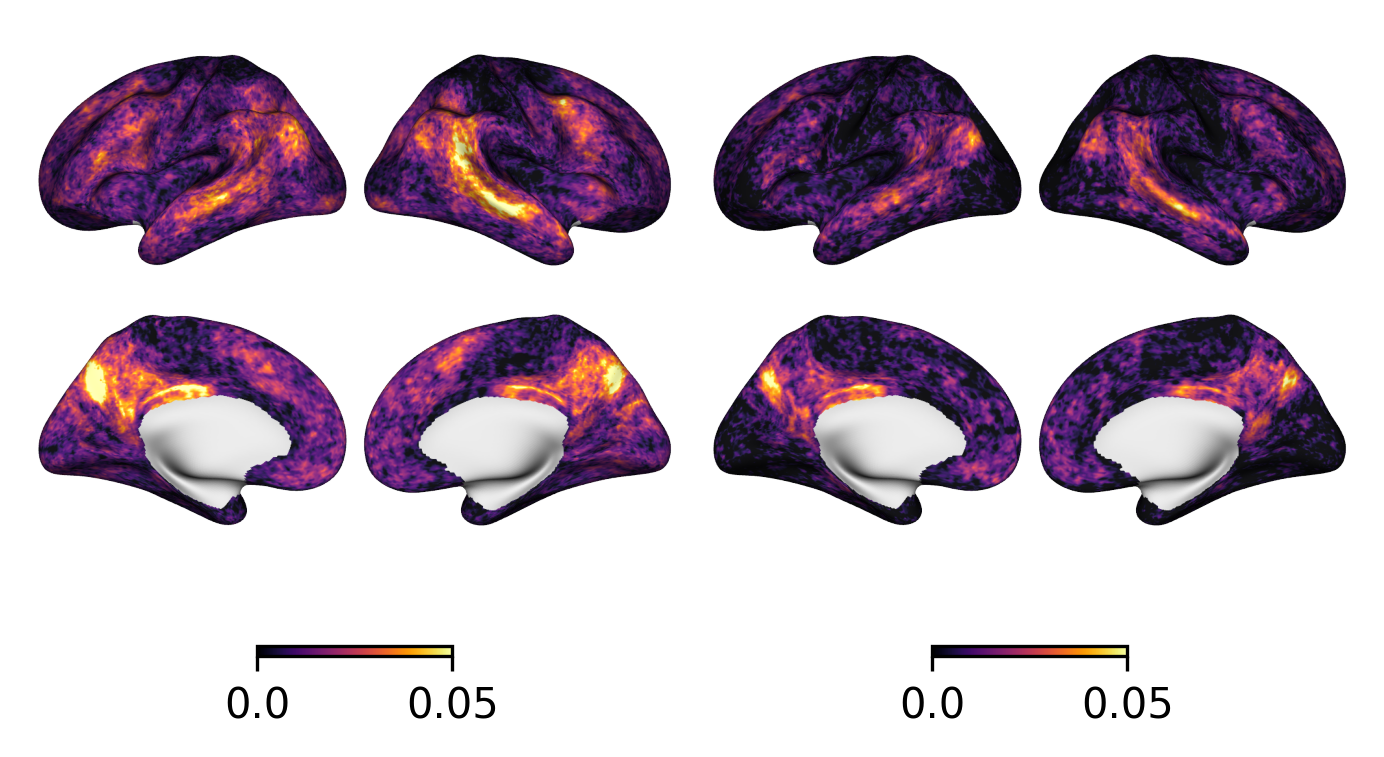

In [101]:
# production
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot(conv_prod_scores.mean(0), vmin=0, vmax=0.05, cmap='inferno', fig=fig, ax=axes[0])
plot.surface_plot(story_prod_scores.mean(0), vmin=0, vmax=0.05, cmap='inferno', fig=fig, ax=axes[1])
fig.show()

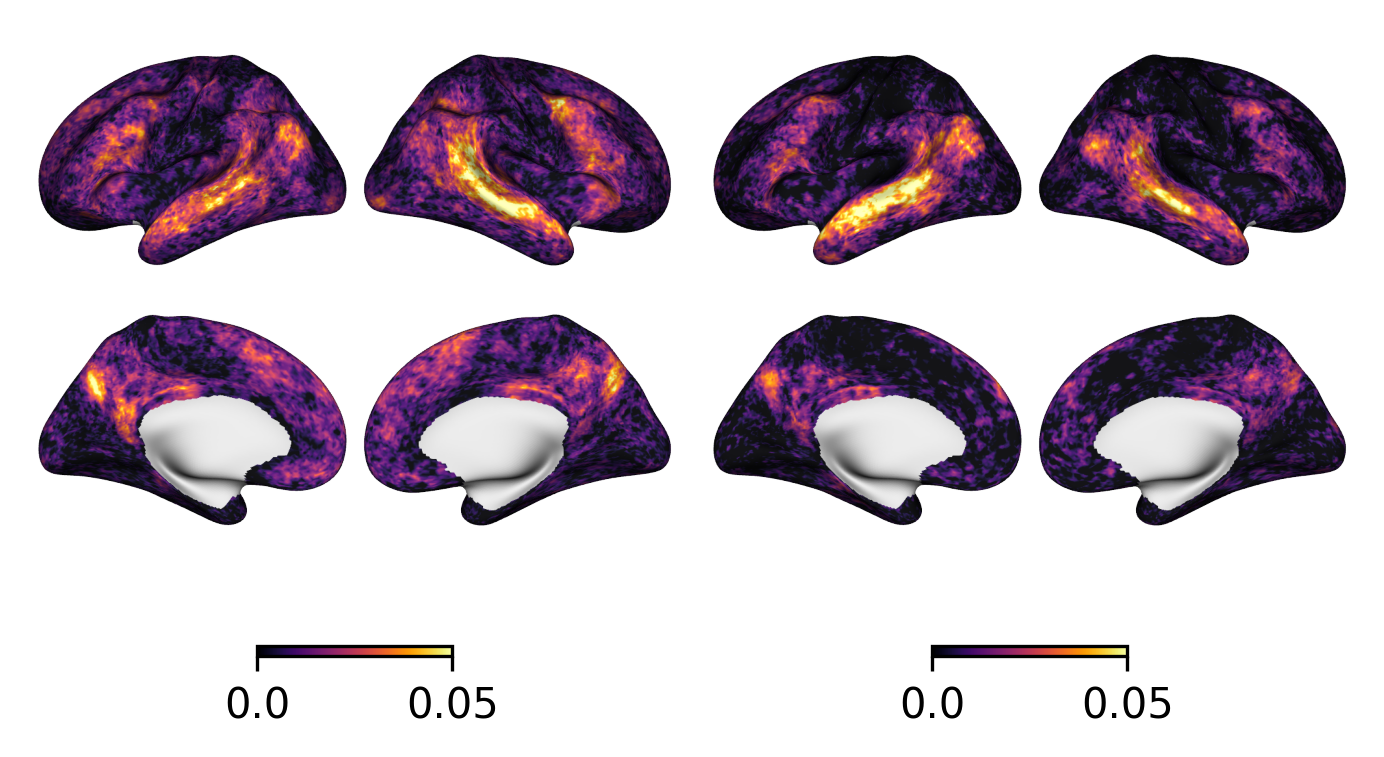

In [102]:
# comprehension
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot(conv_comp_scores.mean(0), vmin=0, vmax=0.05, cmap='inferno', fig=fig, ax=axes[0])
plot.surface_plot(story_comp_scores.mean(0), vmin=0, vmax=0.05, cmap='inferno', fig=fig, ax=axes[1])
fig.show()

### compute sig. difference

In [88]:
from scipy.stats import ttest_rel

In [90]:
conv_prod_scores = conv_prod_scores[..., FG_MASK].mean(-1)
conv_comp_scores = conv_comp_scores[..., FG_MASK].mean(-1)

black_prod_scores = story_prod_scores[..., FG_MASK].mean(-1)
black_comp_scores = story_prod_scores[..., FG_MASK].mean(-1)

conv_comp_scores.shape, black_comp_scores.shape

((55,), (55,))

In [91]:
print((conv_comp_scores.mean() - black_comp_scores.mean()) / conv_comp_scores.mean())
print((conv_prod_scores.mean() - black_prod_scores.mean()) / conv_prod_scores.mean())

0.4087569
0.4918481


In [92]:
print('comp', ttest_rel(conv_comp_scores, black_comp_scores))
print('prod', ttest_rel(conv_prod_scores, black_prod_scores))

comp TtestResult(statistic=3.2280294448780915, pvalue=0.0021214168591717664, df=54)
prod TtestResult(statistic=5.0431023786383875, pvalue=5.501454361197233e-06, df=54)


### scatter plot diff

In [98]:
conv_prod_scores = conv_prod_scores[..., FG_MASK].mean(0)
conv_comp_scores = conv_comp_scores[..., FG_MASK].mean(0)

black_prod_scores = story_prod_scores[..., FG_MASK].mean(0)
black_comp_scores = story_prod_scores[..., FG_MASK].mean(0)

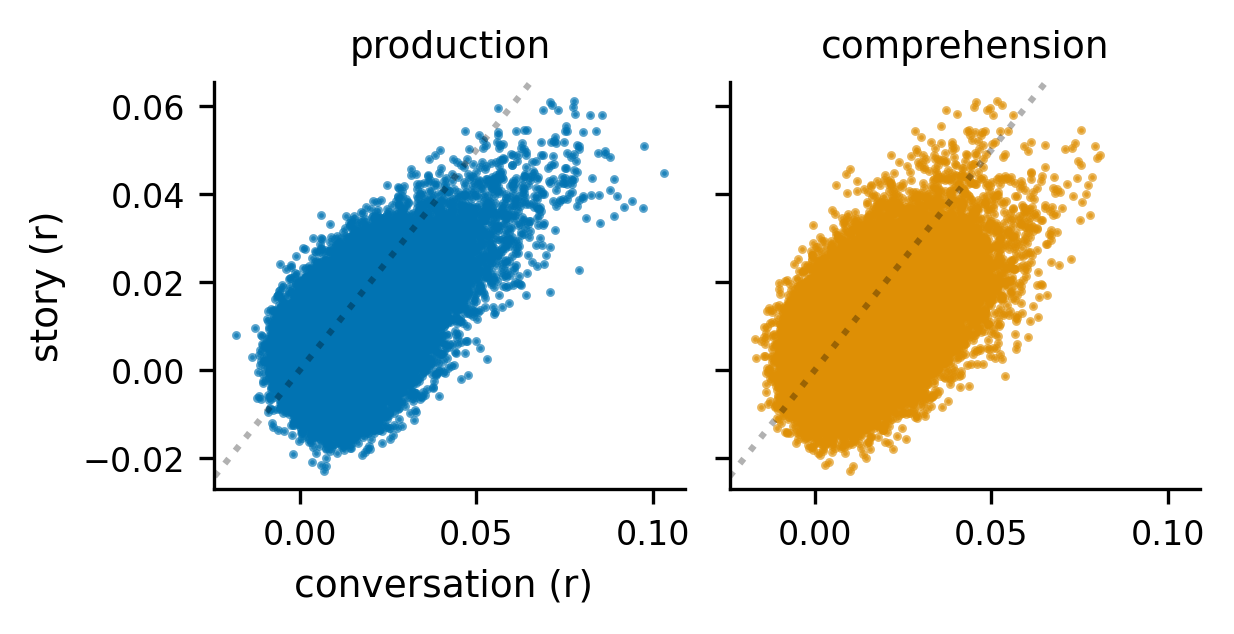

In [99]:
fig, axes = plt.subplots(1, 2, layout='constrained', dpi=300, sharex=True, sharey=True, figsize=(4, 2))
axes[0].scatter(conv_prod_scores, black_prod_scores, marker='.', color=BLU, alpha=0.65, s=5)
axes[1].scatter(conv_comp_scores, black_comp_scores, marker='.', color=ORG, alpha=0.65, s=5)

axes[0].set_xlabel('conversation (r) ')
axes[0].set_ylabel('story (r)')

axes[0].set_title('production')
axes[1].set_title('comprehension')

axes[0].axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dotted')
axes[1].axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dotted')

fig.show()

# black story encoding

In [ ]:
encmodel = "encoding_black"

modelname = 'model-gpt2-2b_layer-24'
features = ["stats", "acoustic", "articulatory", "LLM"]

modelname = 'contextual'
features = ["stats", "LLM"]

In [ ]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        results['black_cv_scores'].append(f['black_cv_scores'][...])

In [ ]:
sub_black_scores = np.stack(results['black_cv_scores'])
avg_black_scores = sub_black_scores.mean((0, 1))
sub_black_scores.shape

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), dpi=300, layout='constrained')
for i, ax in enumerate(axes):
    plot.surface_plot(avg_black_scores[i], fig=fig, ax=ax, vmin=0, cmap='inferno', title=features[i])
fig.show()

In [ ]:
sub_llm_black_scores = sub_black_scores[:, :, -1].mean(1)
sub_llm_black_scores.shape 

In [ ]:
black_p_values = stats.ttest_1samp(sub_llm_black_scores, correlations=True)
black_sigmask = stats.correct_multiple_tests(black_p_values, method='fdr_bh', alpha=0.01)
black_sigmask.sum() 

In [ ]:
avg_llm_black_scores = sub_llm_black_scores.mean(0)
avg_llm_black_scores[black_sigmask].min(), avg_llm_black_scores.max()

In [ ]:
plot.surface_plot(avg_llm_black_scores, vmin=0, cmap='inferno', threshold=~black_sigmask);

# multiple ways to compute encoding performance

In [ ]:
from constants import RUNS, CONV_TRS
from sklearn.model_selection import PredefinedSplit

## exclusive prod/comp

In [ ]:
encmodel, modelname

In [ ]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

run_ids = np.repeat(RUNS, CONV_TRS * 2)
kfold = PredefinedSplit(run_ids)

for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue

    # Y_bold = subject.get_bold(sub, cache)
    subB = subject.get_partner(sub)  # mbc
    Y_bold = subject.get_bold(subB, cache)

    with h5py.File(respath, "r+") as f:
        cv_preds = f["cv_preds"]
        cv_prod_mask = f["cv_prod_mask"]
        cv_comp_mask = f["cv_comp_mask"]

        cv_scores_prod = np.zeros(f['cv_scores_prod'].shape, dtype=np.float32)
        cv_scores_comp = np.zeros(f['cv_scores_comp'].shape, dtype=np.float32)

        for k, (_, test_index) in enumerate(kfold.split([])):
            Y_preds = cv_preds[k]
            Y_test = Y_bold[test_index]

            prod_mask = cv_prod_mask[k]
            comp_mask = cv_comp_mask[k]
            prod_only_mask = prod_mask & ~comp_mask
            comp_only_mask = comp_mask & ~prod_mask

            cv_scores_prod[k] = correlation_score_split(
                Y_test[prod_only_mask], Y_preds[:, prod_only_mask, :]
            )
            cv_scores_comp[k] = correlation_score_split(
                Y_test[comp_only_mask], Y_preds[:, comp_only_mask, :]
            )

        if 'cv_scores_prod_exclusive_mbc' in f:
            del f["cv_scores_prod_exclusive_mbc"]
            del f["cv_scores_comp_exclusive_mbc"]

        f.create_dataset("cv_scores_prod_exclusive_mbc", data=cv_scores_prod)
        f.create_dataset("cv_scores_comp_exclusive_mbc", data=cv_scores_comp)

## test on single subject

In [ ]:
print(all_scores_prod[:, 0, -1].max(-1).argmax())
print(all_scores_comp[:, 0, -2].max(-1).argmax())

In [ ]:
SUBS_STRANGERS[20]

In [ ]:
subA = 138

respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

respath.update(sub=f"{subA:03d}")
print(respath.fpath)
with h5py.File(respath, "r") as f:
    preds = f['cv_preds'][...]
    prod_mask = f['cv_prod_mask'][...]
    comp_mask = f['cv_comp_mask'][...]
    scores_comp = f['cv_scores_comp_exclusive'][...]
    scores_prod = f['cv_scores_prod_exclusive'][...]

# fwd = subject.get_confounds(sub)
dataA = subject.get_bold(subA, cache=cache)
prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)

dataA.shape, preds.shape, prod_boxcar.shape,  prod_mask.shape, scores_prod.shape#, fwd.shape

In [ ]:
prod_only_mask = prod_mask & ~comp_mask
comp_only_mask = comp_mask & ~prod_mask

prod_mask = prod_only_mask
comp_mask = comp_only_mask
(prod_only_mask & comp_only_mask).any()

In [ ]:
vox = scores_prod[0, -1].argmax()  # 19001

print(scores_prod[0, -2:, vox].round(3))
print(scores_comp[0, -2:, vox].round(3))

vox

In [ ]:
fig, axes = plt.subplots(preds.shape[1]+3, 1, figsize=(10, 8), sharex=True)
xaxis = np.arange(240)
axes[0].step(xaxis, prod_mask[0])
axes[1].step(xaxis, comp_mask[0])
axes[2].plot(xaxis, dataA[:240, vox])
for i, j in enumerate(range(3, len(axes))):
    axes[j].plot(xaxis, preds[0, i, ..., vox])
    axes[j].set_ylabel(features[i])

for ax in axes:
    ax.axvspan(62, 66, color='k', alpha=0.2)

fig.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes[0,0].scatter(preds[0, -2, :, vox][prod_mask[0]], dataA[:240, vox][prod_mask[0]], color=BLU)
axes[0,1].scatter(preds[0, -1, :, vox][prod_mask[0]], dataA[:240, vox][prod_mask[0]], color=BLU)
axes[1,0].scatter(preds[0, -2, :, vox][comp_mask[0]], dataA[:240, vox][comp_mask[0]], color=ORG)
axes[1,1].scatter(preds[0, -1, :, vox][comp_mask[0]], dataA[:240, vox][comp_mask[0]], color=ORG)
fig.show()

In [ ]:
# production predictions during comprehension
(preds[0, -2, :, vox][comp_mask[0]] -  1.0750948e-04).nonzero()

In [ ]:
# comprehension predictions during production
(preds[0, -1, :, vox][prod_mask[0]] - 0.07141564).nonzero()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes[0,0].scatter(prod_mask[0], preds[0, -2, :, vox], color=BLU)
axes[0,1].scatter(prod_mask[0], preds[0, -1, :, vox], color=BLU)
axes[1,0].scatter(comp_mask[0], preds[0, -2, :, vox], color=ORG)
axes[1,1].scatter(comp_mask[0], preds[0, -1, :, vox], color=ORG)
fig.show()

# compare with head motion

In [32]:
stat = np.mean

prod_fds = []
comp_fds = []
prod_scs = []
comp_scs = []

for subA in tqdm(SUBS_STRANGERS):
    fd = subject.get_confounds(subA, model_spec=dict(confounds=['framewise_displacement']))
    fd = fd.reshape(5, 240)

    encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        prod_mask = f["cv_prod_mask"][...]
        prod_scores = f["cv_scores_prod_exclusive"][:, -1]
        comp_scores = f["cv_scores_comp_exclusive"][:, -1]
    
    for i in range(5):
        prod_fd = fd[i, prod_mask[i]]
        comp_fd = fd[i, ~prod_mask[i]]
        prod_sc = prod_scores[i]
        comp_sc = comp_scores[i]

        prod_fds.append(stat(prod_fd, axis=-1))
        comp_fds.append(stat(comp_fd, axis=-1))
        prod_scs.append(stat(prod_sc, axis=-1))
        comp_scs.append(stat(comp_sc, axis=-1))


100%|██████████| 58/58 [00:24<00:00,  2.33it/s]


In [34]:
r_prod = pearsonr(prod_fds, prod_scs)
r_comp = pearsonr(comp_fds, comp_scs)
print(r_prod)
print(r_comp)

PearsonRResult(statistic=-0.29060618184056286, pvalue=4.7391092326946167e-07)
PearsonRResult(statistic=-0.20714786900268278, pvalue=0.0003838317051487607)


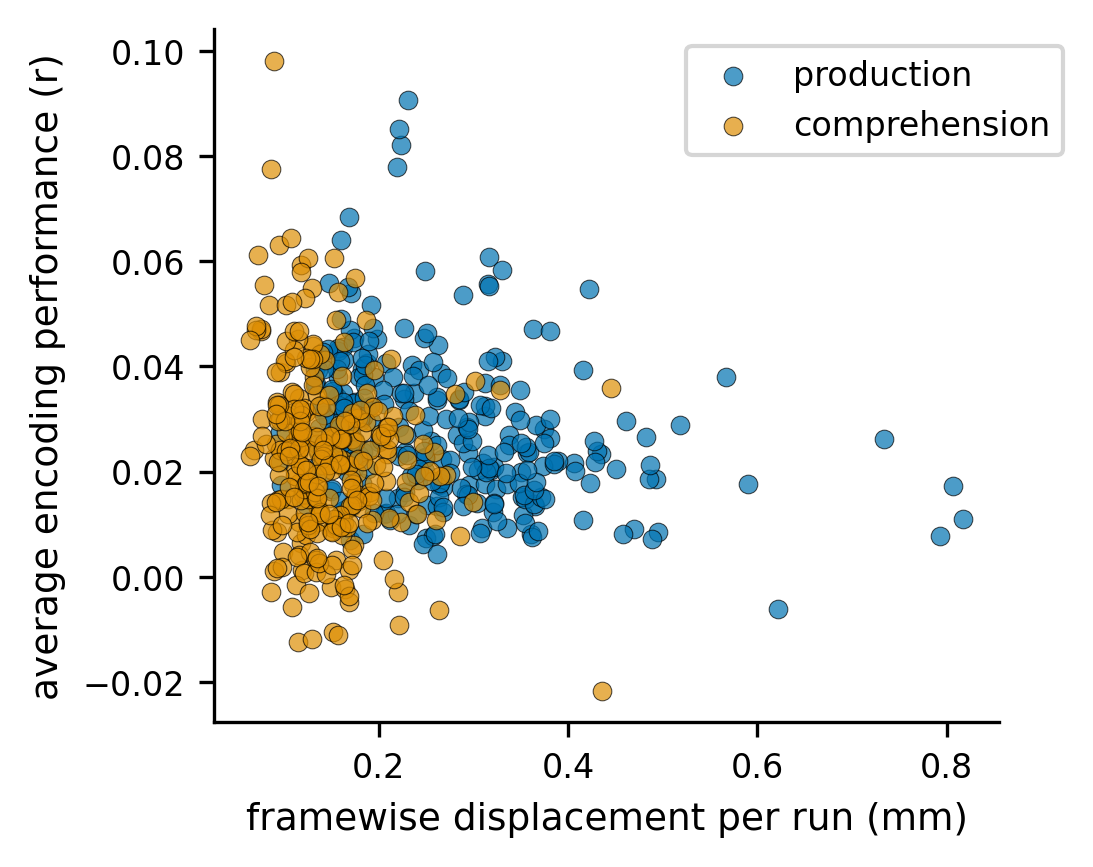

In [42]:
fig, ax = plt.subplots(figsize=(3.375, 3), dpi=300)

ax.scatter(prod_fds, prod_scs, alpha=0.7, c=BLU, s=20, label='production', edgecolors='black', linewidths=0.25)
ax.scatter(comp_fds, comp_scs, alpha=0.7, c=ORG, s=20, label='comprehension', edgecolors='black', linewidths=0.25)
ax.set_xlabel('framewise displacement per run (mm)')
ax.set_ylabel('average encoding performance (r)')
ax.legend(loc="upper left", bbox_to_anchor=(0.58, 1), frameon=True)
fig.show()

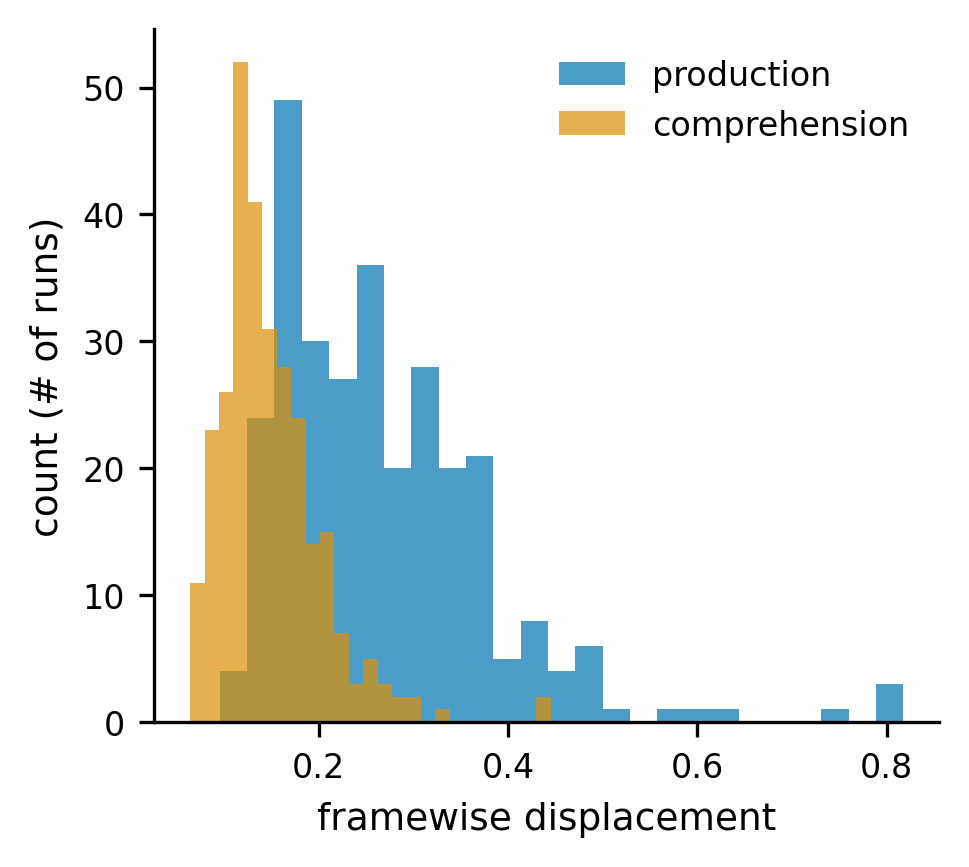

In [38]:
fig, ax = plt.subplots(figsize=(3.375, 3), dpi=300)
ax.hist(prod_fds, bins=25, alpha=0.7, color=BLU, label='production')
ax.hist(comp_fds, bins=25, alpha=0.7, color=ORG, label='comprehension')
ax.legend()
ax.set_xlabel('framewise displacement')
ax.set_ylabel('count (# of runs)')
fig.show()

# visualize/verify regressors

In [ ]:
# import sys
# from importlib import reload
# reload(sys.modules["encoding"])

from encoding import get_regressors, build_regressors, SplitDelayer, SPACES

In [49]:
from scipy.spatial.distance import pdist
from constants import CONVS_STRANGERS

In [ ]:
subA = 105
X, features = build_regressors(subA, spaces=SPACES["joint_nosplit"], modelname='model-gpt2-2b_layer-24', split=False)
rdms = [pdist(X[features[feat]].T, metric='euclidean') for feat in features]
heatmap = np.corrcoef(rdms)

((1200, 1707),
 {'task': slice(0, 2, None),
  'word_stats': slice(2, 5, None),
  'spectral': slice(5, 85, None),
  'articulation': slice(85, 107, None),
  'llm': slice(107, 1707, None)})

In [62]:
[feat.stop - feat.start for feat in features.values()]

[2, 3, 80, 22, 1600]

In [ ]:
heatmaps = []
for conv in tqdm(CONVS_STRANGERS):
    X, features = build_regressors(conv, spaces=SPACES["joint_nosplit"], modelname='model-gpt2-2b_layer-24', split=False)
    rdms = [pdist(X[features[feat]].T, metric='euclidean') for feat in features]
    heatmap = np.corrcoef(rdms)
    heatmaps.append(heatmap)
heatmap = np.stack(heatmaps).mean(0)

100%|██████████| 29/29 [02:25<00:00,  5.02s/it]


In [58]:
# plot `heatmap` using matplotlib imshow and display the actual values on the heatmap
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
cax = ax.matshow(heatmap, cmap='Reds', vmin=0, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(features)))
ax.set_yticks(range(len(features)))
ax.set_xticklabels(features, rotation=45, ha='left')
ax.set_yticklabels(features)
for (i, j), val in np.ndenumerate(heatmap):
    ax.text(j, i, f"{val:0.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black', fontsize=8)
fig.show()

In [ ]:
delayer = SplitDelayer(delays=[0, 1, 2, 3, 4, 5])

In [ ]:
# regressors = get_regressors(subA, modelname='model-gpt2-2b_layer-24', split=True)
# regressors.keys()

In [ ]:
vox

In [ ]:
space = SPACES['joint']
X, space_features = build_regressors(subA, modelname='model-gpt2-2b_layer-24', spaces=space, split=True)
subA, X.shape, space_features

In [ ]:
x_trial = X[:240]
x_trial.shape

In [ ]:
prod_feature = x_trial[:, space_features['prod_llm'].start]
comp_feature = x_trial[:, space_features['comp_llm'].start]

plt.plot(prod_feature)
plt.plot(comp_feature)
plt.show()

In [ ]:
prod_feature_delay = delayer.fit_transform(prod_feature[:, None])
comp_feature_delay = delayer.fit_transform(comp_feature[:, None])

In [ ]:
prod_feature_delay[:10]

In [ ]:
in_prod = prod_feature_delay.any(-1)
in_comp = comp_feature_delay.any(-1)

In [ ]:
in_prod & in_comp

In [ ]:
xaxis = np.arange(120)
plt.step(xaxis, x_trial[:120, 0]*.5, color='b')
plt.step(xaxis, x_trial[:1250, 1]*.25, color='r')
delayer = SplitDelayer(delays=[0, 1, 2, 3, 4, 5])
plt.step(xaxis, delayer.fit_transform(x_trial[:120, 0:1]).any(-1)*.75, color='b', ls='--')
plt.step(xaxis, delayer.fit_transform(x_trial[:120, 1:2]).any(-1), color='r', ls='--')
plt.show()

In [ ]:
x_feature = x_trial[:, features['task']]
n_vars = x_feature.shape[1]

fig, axes = plt.subplots(n_vars, 1, sharex=True)

xaxis = np.arange(120)
for i, ax in enumerate(axes):
    ax.step(xaxis, x_feature[:, i])

fig.show()

In [ ]:
x_feature = x_trial[:, features['spectral']]
n_vars = x_feature.shape[1]

plt.matshow(x_feature.T, cmap='coolwarm', vmin=-.9, vmax=.9)
plt.colorbar()

x_feature.shape

In [ ]:
x_feature = x_trial[:, features['articulation']].T
n_vars = x_feature.shape[1]

plt.matshow(x_feature, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()

x_feature.shape

In [ ]:
x_feature = x_trial[:, features['prod_semantic']].T
n_vars = x_feature.shape[1]

plt.matshow(x_feature[:40], cmap='coolwarm', vmin=-1, vmax=1)
# plt.colorbar()

x_feature.shape

In [ ]:
x_feature = x_trial[:, features['comp_semantic']].T
n_vars = x_feature.shape[1]

plt.matshow(x_feature[:40], cmap='coolwarm', vmin=-1, vmax=1)
# plt.colorbar()

x_feature.shape